### Adapted from `q1.py`

In [274]:
##Script to read simulation snapshots departure time and location. Assign agent location to building.
##Global imports
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas
from sklearn.neighbors import NearestNeighbors
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
ls

README.md                   scripts/
data/                       snapshot_to_building.ipynb


### Separated start and end functions to return separate dataframes instead of a tuple

In [181]:
##Read simulation snapshot departure time.
sim_snap = pd.read_csv("data/vehicle_data/Simulation_Snapshot/Snapshot_small.csv")
def start_df(sim_snap_df:str,sim_start,sim_end):
    sim_snap_df = sim_snap.groupby('VEHICLE')
    sim_start = pd.DataFrame(sim_snap_df.head(1))
    return sim_start

def end_df(sim_snap_df:str,sim_end):
    sim_snap_df = sim_snap.groupby('VEHICLE')
    sim_end = pd.DataFrame(sim_snap_df.tail(1))
    return sim_end

### Let's use a geojson vehicle snapshot instead of csv

In [163]:
sim_snap_geojson = geopandas.read_file("data/vehicle_data/Simulation_Snapshot/snapshot_small.geojson")
def start(sim_snap_df:str,sim_start:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_start_gpd = sim_snap_df.head(1)
    return sim_start_gpd

def end(sim_snap_df:str,sim_end:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_end_gpd = sim_snap_df.tail(1)
    return sim_end_gpd

In [294]:
##Generate plots.Visualize start and end locations.
def plot_end(sim_end_gpd):
    building_map=geopandas.read_file("data/building_data/Building_Footprints/buildings_clipped.geojson")
    fig,ax = plt.subplots(figsize = (15,15))
    building_map.plot(ax=ax)
    building_map.plot(ax=ax)
    ##set layer crs
    ##sim_end_gpd.to_crs(epsg=26916).plot(ax=ax) ****

### Can't seem to get the simulation geopandas file to plot on top of the buildings.

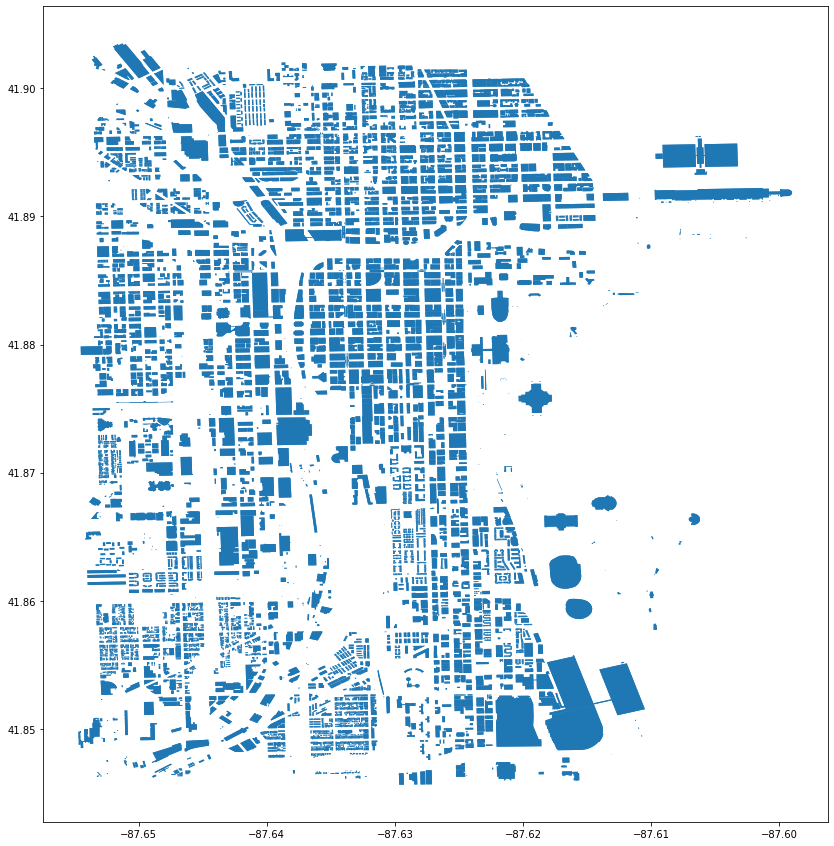

In [295]:
plot_end(sim_end_gpd)

### KNN using building centroids
I think we have to set a seed and use training and test data for this function - although we just want to calculate minimum euclidean distances - let's come back to this.

##### Regardless, the building centroids will be the dataset upon which we match the vehicle locations.

In [211]:
sim_end=end_df(sim_snap,'3:00')
centroids=pd.read_csv('data/building_data/Building_Footprints/centroids_clipped.csv')
vehicles_coord=sim_end[['X_COORD','Y_COORD']]
centroids_coord=centroids[['xcoord','ycoord']]

In [ ]:
X_train, X_train,y_test,y_test=train_test_split(X,y,test_size=0.2, train_size=0.7,random_state=0, stratify=y)
knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean',p=2)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

In [222]:
neigh = NearestNeighbors(n_neighbors=2)
knn=neigh.fit(centroids_coord)

In [265]:
X = sim_end[['X_COORD','Y_COORD']]
knn_centroids=neigh.kneighbors(X, return_distance=True)
#knn_centroids=pd.DataFrame(knn_centroids[1],knn_centroids[0])
knn_dist=pd.DataFrame(knn_centroids[0])
knn_dist
knn_idx=pd.DataFrame(knn_centroids[1])
knn_centroids=[knn_idx,knn_dist]
knn_centroids

[         0     1
 0      122   493
 1     1164  1695
 2     1104   281
 3       98  1150
 4      122   493
 ...    ...   ...
 1448   705  1468
 1449  2264  1903
 1450   705  1468
 1451    51   620
 1452  1468   310
 
 [1453 rows x 2 columns],                0           1
 0     381.550754  393.770211
 1      91.620571  122.685738
 2      69.709055   70.019465
 3      37.540517   50.268252
 4     468.424436  477.682025
 ...          ...         ...
 1448  152.878803  179.593138
 1449  449.450655  466.024853
 1450  158.130126  174.067599
 1451   63.633621   85.992266
 1452  146.493136  167.859599
 
 [1453 rows x 2 columns]]

In [271]:
knn_centroids=pd.concat([knn_idx, knn_dist], axis=1)
knn_centroids.columns=['idx1','idx2','d1','d2']
knn_centroids

,idx1,idx2,d1,d2
0,122,493,381.550754,393.770211
1,1164,1695,91.620571,122.685738
2,1104,281,69.709055,70.019465
3,98,1150,37.540517,50.268252
4,122,493,468.424436,477.682025
...,...,...,...,...
1448,705,1468,152.878803,179.593138
1449,2264,1903,449.450655,466.024853
1450,705,1468,158.130126,174.067599
1451,51,620,63.633621,85.992266


## Question: 
We want to hold the attributes in the vehicles dataframe that are not used in the knn algorithm and connect them with the output. How can I connect the knn fit with the original dataset?

In [217]:
def knn_map(vehicle_id:int,end_time:str,n_neighbors:str):
    sim_snap_geojson = geopandas.read_file("data/vehicle_data/Simulation_Snapshot/snapshot_small.geojson")
    sim_end=end(sim_snap_geojson,end_time)
    
    centroids_coord=centroids[['xcoord','ycoord']]
    X = sim_end[['X_COORD','Y_COORD']]

    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    knn=neigh.fit(centroids_coord)
    
    knn_centroids=neigh.kneighbors(X, return_distance=True)
    
    knn_dist=pd.DataFrame(knn_centroids[0])
    knn_idx=pd.DataFrame(knn_centroids[1])
    knn_centroids=pd.concat([knn_idx, knn_dist], axis=1)
    knn_centroids=[knn_idx['idx',vehicle_id],:]
    
    return knn_centroids

In [ ]:
def count_agents(building_id:int):
    building_counts=knn_centroids['idx1',building_id].count()
    return building_counts